# ABCD IMAGE CLASSIFIER
A Convolutional Neural Network made with PyTorch for efficient image classification. It is trained on the EMNIST dataset on the balanced split. It takes in a 28 px by 28 px binary image and classifies it, returning a number from 0 to 3, corresponds to the letters A to D.

**Metrics**:

Parameter Count: 79,428

Average loss: 0.0076

Accuracy: 98%

## IMPORT MODULES AND SET HYPERPARAMETERS

In [30]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For visualizing
import matplotlib.pyplot as plt

In [31]:
# Define hyperparameters
BATCH_SIZE = 100
EPOCHS = 10
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001

INPUT_CHANNELS = 1
OUTPUT_CLASSES = 4
CONV1_CHANNELS = 16
CONV2_CHANNELS = 32
CONV_KERNEL_SIZE = 5
MAX_POOL_KERNEL_SIZE = 2
FCL1_CHANNELS = CONV2_CHANNELS * 4 * 4
FCL2_CHANNELS = 128

## DATA PREPARATION

In [32]:
# Define a custom transform to binarize the images
class Binarize(object):
    def __call__(self, img):
        return (img > 0.5).float()

In [33]:
# Define the transformations
transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    transforms.ToTensor(),
    Binarize()
])

In [34]:
# Load the EMNIST dataset
emnist_train_dataset = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transform)
emnist_test_dataset = datasets.EMNIST(root="./data", split="balanced", train=False, download=True, transform=transform)

In [35]:
# Labels for A, B, C, and D in EMNIST
target_labels = [10, 11, 12, 13]

# Filter the dataset to get images labeled A, B, C, and D
filtered_train_indices = [i for i in range(len(emnist_train_dataset)) if emnist_train_dataset.targets[i] in target_labels]
train_data = torch.utils.data.Subset(emnist_train_dataset, filtered_train_indices)

filtered_test_indices = [i for i in range(len(emnist_test_dataset)) if emnist_test_dataset.targets[i] in target_labels]
test_data = torch.utils.data.Subset(emnist_test_dataset, filtered_test_indices)


In [36]:
# Define train and test dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## VISUALIZATION

In [37]:
# Set a counter variable for visualization
counter = 0

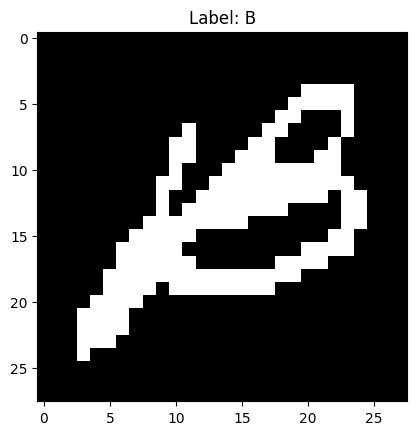

In [38]:
# Visualize a sample image after binarization and filtration
sample_image, sample_label = test_data[counter]
counter += 1
sample_image = sample_image.squeeze().numpy()
mapping = ["A", "B", "C", "D"]
label_string = mapping[sample_label - 10]

plt.imshow(sample_image, cmap="gray")
plt.title(f"Label: {label_string}")
plt.show()

## MODEL CLASS DEFINITION

In [39]:
# Define the CNN model
class ABCDClassifier(nn.Module):

  def __init__(self):
    super(ABCDClassifier, self).__init__()

    self.conv1 = nn.Conv2d(INPUT_CHANNELS, CONV1_CHANNELS, kernel_size=CONV_KERNEL_SIZE)
    self.conv2 = nn.Conv2d(CONV1_CHANNELS, CONV2_CHANNELS, kernel_size=CONV_KERNEL_SIZE)
    self.conv2_drop = nn.Dropout2d(p=DROPOUT_RATE)
    self.fc1 = nn.Linear(FCL1_CHANNELS, FCL2_CHANNELS)
    self.fc2 = nn.Linear(FCL2_CHANNELS, OUTPUT_CLASSES)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), MAX_POOL_KERNEL_SIZE))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), MAX_POOL_KERNEL_SIZE))
    x = x.view(-1, FCL1_CHANNELS)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=DROPOUT_RATE, training=self.training)
    x = self.fc2(x)

    return F.softmax(x, dim=1)

## TRAIN AND TEST FUNCTION DEFINITION

In [40]:
# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = ABCDClassifier().to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Define the train function
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    converted_indices = target - 10
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, converted_indices)
    loss.backward()
    optimizer.step()
    if batch_idx == 0:
      print(f"Train Epoch: {epoch}")
    if batch_idx % 20 == 0:
      print(f"[{batch_idx * len(data)} / {len(train_loader.dataset)} ({100.0 * batch_idx * len(data)/ len(train_loader.dataset):.0f}%)]\tLoss: {loss.item():.6f}")

# Define the test function
def test():
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      converted_indices = target - 10
      output = model(data)
      test_loss += loss_fn(output, converted_indices).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(converted_indices.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print(f"\nTest Set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.0f}%)\n")

## TRAINING THE MODEL

In [41]:
# Train and test 10 epochs
for epoch in range(1, EPOCHS + 1):
  train(epoch)
  test()

# Determine the parameter count of the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Model Parameter Count: {num_params}")

Train Epoch: 1
[0 / 9600 (0%)]	Loss: 1.385758
[2000 / 9600 (21%)]	Loss: 1.166502
[4000 / 9600 (42%)]	Loss: 0.908033
[6000 / 9600 (62%)]	Loss: 0.876347
[8000 / 9600 (83%)]	Loss: 0.842848

Test Set: Average loss: 0.0081, Accuracy 1492/1600 (93%)

Train Epoch: 2
[0 / 9600 (0%)]	Loss: 0.818675
[2000 / 9600 (21%)]	Loss: 0.810343
[4000 / 9600 (42%)]	Loss: 0.815025
[6000 / 9600 (62%)]	Loss: 0.812238
[8000 / 9600 (83%)]	Loss: 0.823218

Test Set: Average loss: 0.0079, Accuracy 1528/1600 (96%)

Train Epoch: 3
[0 / 9600 (0%)]	Loss: 0.813530
[2000 / 9600 (21%)]	Loss: 0.796925
[4000 / 9600 (42%)]	Loss: 0.772125
[6000 / 9600 (62%)]	Loss: 0.833088
[8000 / 9600 (83%)]	Loss: 0.803852

Test Set: Average loss: 0.0079, Accuracy 1535/1600 (96%)

Train Epoch: 4
[0 / 9600 (0%)]	Loss: 0.808162
[2000 / 9600 (21%)]	Loss: 0.765743
[4000 / 9600 (42%)]	Loss: 0.778205
[6000 / 9600 (62%)]	Loss: 0.783839
[8000 / 9600 (83%)]	Loss: 0.784179

Test Set: Average loss: 0.0078, Accuracy 1545/1600 (97%)

Train Epoch: 5
[0 / 

## SAVING AND DOWNLOADING THE MODEL STATE DICTIONARY

In [42]:
# Save model state dict
torch.save(model.state_dict(), "image_classifier.pth")

In [43]:
# Download model state dict
from google.colab import files

files.download("image_classifier.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>